<a href="https://colab.research.google.com/github/Ohsoo46/AIFFEL_QUEST/blob/main/12_1_%EA%B1%B0%EC%9A%B8%EC%95%84_%EA%B1%B0%EC%9A%B8%EC%95%84%5B%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Step 1. tf_flowers 데이터셋 다운로드

import tensorflow as tf
import tensorflow_datasets as tfds

# tf_flowers 데이터셋 로드 (자동 다운로드됨)
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
    as_supervised=True,   # (image, label) 형태
    with_info=True
)

print(" tf_flowers 다운로드 완료")
print("클래스 개수:", ds_info.features["label"].num_classes)
print("클래스 이름:", ds_info.features["label"].names)

print("데이터 개수")
print("train:", tf.data.experimental.cardinality(ds_train).numpy())
print("val  :", tf.data.experimental.cardinality(ds_val).numpy())
print("test :", tf.data.experimental.cardinality(ds_test).numpy())


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.W0K1NM_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
 tf_flowers 다운로드 완료
클래스 개수: 5
클래스 이름: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
데이터 개수
train: 2936
val  : 367
test : 367


# step 2

In [3]:
import tensorflow as tf

IMG_SIZE = 224          # VGG16 기본 입력 크기(224x224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def format_example(image, label):
    # 1) dtype 통일 + 크기 통일
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32)

    # 2) [0,255] -> [0,1] 정규화 (가장 기본)
    image = image / 255.0
    return image, label

# 1) resize/normalize 적용
train_ds = ds_train.map(format_example, num_parallel_calls=AUTOTUNE)
val_ds   = ds_val.map(format_example, num_parallel_calls=AUTOTUNE)
test_ds  = ds_test.map(format_example, num_parallel_calls=AUTOTUNE)

# 2) train은 섞고(shuffle) 배치(batch)
train_batches = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# val/test는 섞지 않고 배치(batch)
validation_batches = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_batches       = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print(" Step 2 완료: train/val/test batches 생성됨")


 Step 2 완료: train/val/test batches 생성됨


In [4]:
for images, labels in train_batches.take(1):
    print("images shape:", images.shape)   # (BATCH_SIZE, 224, 224, 3)
    print("labels shape:", labels.shape)   # (BATCH_SIZE,)
    print("pixel range:", float(tf.reduce_min(images)), "~", float(tf.reduce_max(images)))
    print("labels sample:", labels[:10].numpy())


images shape: (32, 224, 224, 3)
labels shape: (32,)
pixel range: 0.0 ~ 1.0
labels sample: [1 1 3 3 0 1 2 3 3 2]


Step 2-3 셀:  실제 이미지 몇 장 확인


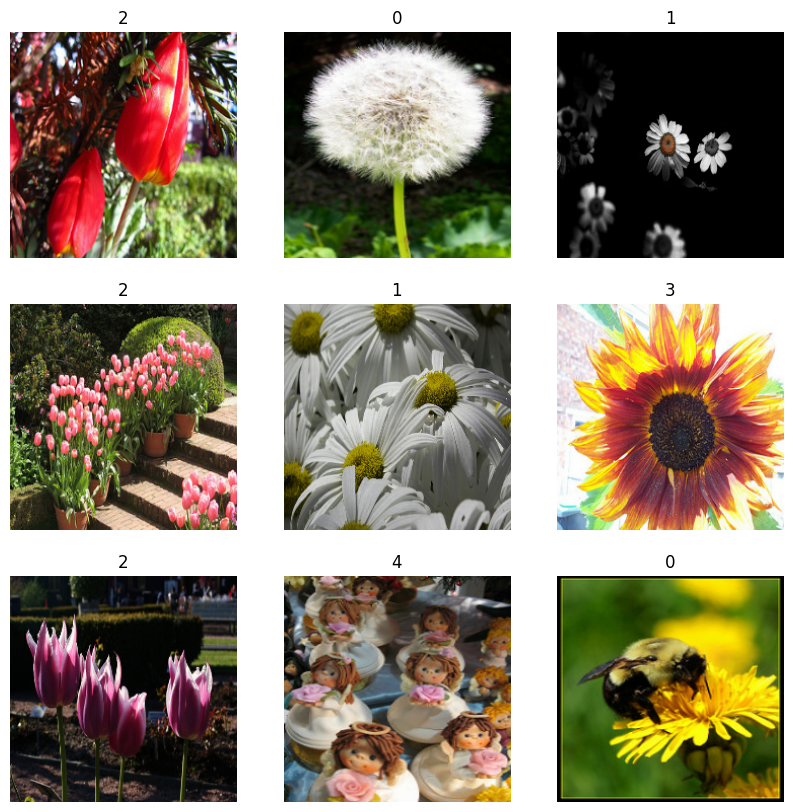

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_batches.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(int(labels[i]))
        plt.axis("off")
plt.show()


step 3- 1: VGG16 기반 모델 설계: Transfer Learning

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

NUM_CLASSES = 5

# VGG16 base model (ImageNet 사전학습)
base_model = keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # Step 4에서 1차 학습은 freeze로 진행

inputs = keras.Input(shape=(224, 224, 3))

#  VGG16은 보통 preprocess_input을 쓰는 게 정석 (BGR/mean 처리)
x = keras.applications.vgg16.preprocess_input(inputs * 255.0)  # 현재 0~1 이라서 255로 되돌린 뒤 preprocess

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)

# FC head (원하면 여기서 구조/드롭아웃/BN 바꿔볼 수 있음)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ multiply[0][0]    │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ multiply[0][0]    │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5)         │      1,285 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,847,301 (56.64 MB)

 Trainable params: 132,613 (518.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

step 3-2 : 컴파일

In [7]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print(" Step 3 완료: 모델 설계 + 컴파일 완료")


 Step 3 완료: 모델 설계 + 컴파일 완료


📌 Step 3에서 “cats_vs_dogs와 달라진 부분” 정리

cats_vs_dogs: 2 클래스 → Dense(1, sigmoid) 또는 Dense(2, softmax)

tf_flowers: 5 클래스 → Dense(5, softmax)

라벨이 정수니까 → sparse_categorical_crossentropy

step4-1모델 학습 (epoch은 10부터)

In [8]:
EPOCHS = 1

history = model.fit(
    train_batches,
    validation_data=validation_batches,
    epochs=EPOCHS
)


92/92 ━━━━━━━━━━━━━━━━━━━━ 49s 361ms/step - accuracy: 0.6250 - loss: 2.0584 - val_accuracy: 0.8801 - val_loss: 0.3984


step 5 모델 성능 평가하기

In [10]:
val_loss, val_acc = model.evaluate(validation_batches, verbose=0)
test_loss, test_acc = model.evaluate(test_batches, verbose=0)

print(f"[Validation] acc={val_acc:.3f}, loss={val_loss:.3f}")
print(f"[Test]       acc={test_acc:.3f}, loss={test_loss:.3f}")


[Validation] acc=0.880, loss=0.398
[Test]       acc=0.823, loss=0.517


step 5-2  모델 저장

In [11]:
model.save("tf_flowers_vgg16_epoch1.keras")
print(" 모델 저장 완료")


 모델 저장 완료


Step 6. 모델 활용하기 (최소 버전)
6-1) (선택) Colab에 이미지 1장 업로드해서 예측

In [12]:
from google.colab import files
uploaded = files.upload()  # 이미지 1장 업로드
img_path = list(uploaded.keys())[0]
print("uploaded:", img_path)


Saving MM_beauty_research_ai_dev-2.png to MM_beauty_research_ai_dev-2.png
uploaded: MM_beauty_research_ai_dev-2.png


In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

class_names = ds_info.features["label"].names
IMG_SIZE = 224

# 이미지 로드 + (224,224) 리사이즈
img = keras.utils.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
x = keras.utils.img_to_array(img)          # (224,224,3)
x = x / 255.0                              # Step 2와 동일하게 0~1 정규화
x = np.expand_dims(x, axis=0)              # (1,224,224,3)

# 예측
probs = model.predict(x, verbose=0)[0]
pred_idx = int(np.argmax(probs))

print(" Prediction:", class_names[pred_idx])
print(" Prob:", float(probs[pred_idx]))

# (선택) 상위 3개도 같이 보기
top3 = probs.argsort()[-3:][::-1]
print("\nTop-3:")
for i in top3:
    print(f" - {class_names[int(i)]}: {float(probs[int(i)]):.4f}")


 Prediction: sunflowers
 Prob: 0.4782372713088989

Top-3:
 - sunflowers: 0.4782
 - tulips: 0.3109
 - roses: 0.2029
